In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17473889593984327756
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7040857932066922136
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 29703400320
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1457610740359763337
physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 30988702848
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 4669994859871947726
physical_device_desc: "device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limi

In [2]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Reshape, Input, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.engine.topology import Layer
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras import backend as K

from attention import Attention

Using TensorFlow backend.


In [3]:
version='v7'

# 데이터 불러오기

In [4]:
train_x_df = pd.read_csv("./data/train_x_df.csv")
train_y_df = pd.read_csv("./data/train_y_df.csv")
test_x_df = pd.read_csv("./data/test_x_df.csv")

In [5]:
train_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534
...,...,...,...,...,...,...,...,...,...,...,...,...
10572175,7660,1375,8,1.000277,1.000499,1.000000,1.000388,0.574281,103.592369,0.665410,0.266649,48.100475
10572176,7660,1376,8,1.000333,1.000388,0.999834,1.000277,1.350429,243.535217,0.804037,0.487857,87.985291
10572177,7660,1377,8,1.000277,1.000388,0.999834,1.000277,0.692170,124.846756,0.781857,0.360461,65.018936
10572178,7660,1378,8,1.000166,1.000222,0.999778,1.000056,0.556481,100.351929,0.670955,0.296588,53.486565


In [6]:
train_y_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.999389,0.999630,0.999261,0.999385,0.001187,9.632785,0.012565,0.000605,4.904978
1,0,1,9,0.999593,1.000000,0.999265,0.999266,0.004197,34.052364,0.020572,0.003014,24.453999
2,0,2,9,0.999266,0.999618,0.999262,0.999322,0.003942,31.981472,0.016630,0.002967,24.069899
3,0,3,9,0.999322,0.999388,0.998917,0.999387,0.003663,29.709074,0.019463,0.002362,19.158766
4,0,4,9,0.999015,0.999015,0.997631,0.998399,0.003266,26.466251,0.030180,0.001533,12.421005
...,...,...,...,...,...,...,...,...,...,...,...,...
919315,7660,115,8,1.002662,1.003382,1.002606,1.002717,0.957148,173.131668,0.510148,0.476201,86.143784
919316,7660,116,8,1.002551,1.002606,1.001608,1.001830,1.537946,277.939087,0.465787,1.061331,191.801056
919317,7660,117,8,1.001830,1.002384,1.001497,1.001608,1.203197,217.364487,0.637684,0.971337,175.472198
919318,7660,118,8,1.001608,1.001941,1.001109,1.001386,1.252859,226.264069,1.003660,0.449899,81.251137


In [7]:
test_x_df

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,7661,0,7,0.993560,0.993560,0.990477,0.991021,587512.625000,534685.312500,553.533691,76317.687500,69457.835938
1,7661,1,7,0.990771,0.993048,0.990357,0.992689,616675.437500,560815.937500,514.306885,291661.375000,265331.843750
2,7661,2,7,0.992710,0.993560,0.991316,0.991795,670641.687500,610829.625000,361.758240,288066.125000,262389.562500
3,7661,3,7,0.992318,0.992318,0.990695,0.990727,365400.343750,332430.937500,329.069244,113585.000000,103350.929688
4,7661,4,7,0.991141,0.991152,0.989158,0.989605,245272.531250,222917.734375,481.617889,70405.781250,63988.847656
...,...,...,...,...,...,...,...,...,...,...,...,...
738295,8195,1375,6,0.997053,0.999276,0.997053,0.999069,1.633000,315.307526,1.375175,0.878884,169.736862
738296,8195,1376,6,0.999121,1.000569,0.998552,1.000569,1.478406,285.818695,1.039136,0.455307,88.052055
738297,8195,1377,6,1.000569,1.001086,0.999121,0.999690,0.848792,164.188950,0.935739,0.445028,86.055450
738298,8195,1378,6,0.999690,1.000207,0.998863,1.000000,1.099217,212.537872,0.723776,0.410302,79.334801


# train_x + train_y

trans_train_y_df = train_y_df.copy()
trans_train_y_df

for before, after in tqdm(zip(range(0, 120), range(1380, 1501))):
    trans_train_y_df['time'] = trans_train_y_df['time'].replace([before], after)

trans_train_y_df['time'].value_counts()

trans_train_y_df.describe()

train = pd.concat([train_x_df, trans_train_y_df])
train

train_concat = train.sort_values(by=['sample_id', 'time'], axis=0)
train_concat.reset_index(drop=True, inplace=True)

train_concat

In [8]:
train_x = tf.reshape(train_x_df.iloc[:,3:7].values, [-1, 1380, 4])
train_y = tf.reshape(train_y_df.iloc[:,3:7].values, [-1, 120, 4])
test_x = tf.reshape(test_x_df.iloc[:,3:7].values, [-1, 1380, 4])

In [9]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)

(7661, 1380, 4)
(7661, 120, 4)
(535, 1380, 4)


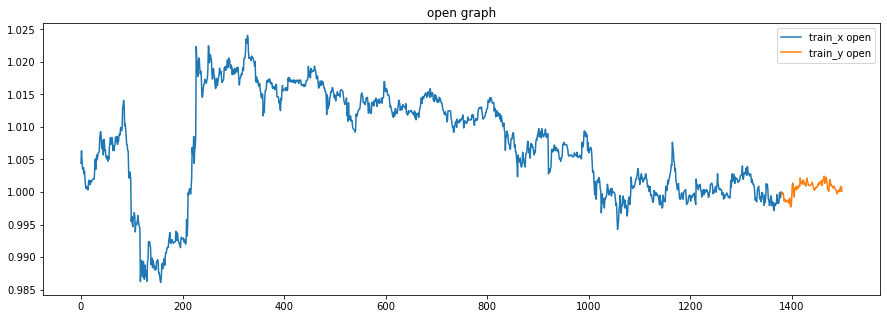

In [10]:
row=476

plt.figure(figsize=(15,5))

plt.plot(train_x[row,:,0], label='train_x open')
plt.plot(np.arange(train_x.shape[1],train_x.shape[1]+ train_y.shape[1]), train_y[row, :, 0], label='train_y open')
plt.legend()
plt.title('open graph')
plt.show()

In [11]:
input_window = 170
output_window = 60
num_features = 4
window = input_window + output_window

train_window_x= np.zeros((train_x.shape[0], train_x.shape[1]//230, input_window, num_features))
train_window_y= np.zeros((train_x.shape[0], train_x.shape[1]//230, output_window, num_features))
print(train_window_x.shape, train_window_y.shape)

for example in tqdm(range(train_x.shape[0])):
    for start in range(0,  train_x.shape[1]-(input_window+output_window), 230):
        end = start+input_window
        train_window_x[example, start//230, :, :] = train_x[example, start:end, :]
        train_window_y[example, start//230, :, :] = train_x[example, end:end+output_window, :]

  0%|▍                                                                              | 38/7661 [00:00<00:21, 360.36it/s]

(7661, 6, 170, 4) (7661, 6, 60, 4)


100%|█████████████████████████████████████████████████████████████████████████████| 7661/7661 [00:20<00:00, 378.03it/s]


In [12]:
new_train_x = tf.reshape(train_window_x, [-1, input_window, num_features])
new_train_y = tf.reshape(train_window_y, [-1, output_window, num_features])

In [13]:
print(new_train_x.shape)
print(new_train_y.shape)

(45966, 170, 4)
(45966, 60, 4)


# 학습하기

In [14]:
time = new_train_x.shape[1]
OUT_STEPS = new_train_y.shape[1]


with tf.device('/gpu:1'):
    input_1 = Input(shape=(time, num_features), dtype='float32')
    lstm_1 = LSTM(64, return_sequences=True)(input_1)
    lstm_2 = LSTM(64, return_sequences=True)(lstm_1)
    #lstm_3 = LSTM(32, return_sequences=True)(lstm_2)
    #lstm_4 = LSTM(32, return_sequences=True)(lstm_3)
    att_1 = Attention(64)(lstm_2)
    output_1 = Dense(OUT_STEPS * num_features)(att_1)
    output_reshape = Reshape([OUT_STEPS, num_features])(output_1)
    
    model = Model(inputs = [input_1], outputs = [output_reshape])
    
    model.summary()
    
    #optimizer = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer='rmsprop', loss='mae')

    es = EarlyStopping(monitor='val_loss', patience=20)
    model_path = './save_models/Attention_based_LSTM_{}'.format(version) + '_{epoch:02d}_{val_loss:.5f}.h5'
    mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, mode='auto')

    history = model.fit(new_train_x, new_train_y, epochs=30, batch_size=128, validation_split=0.2, callbacks=[es, mc])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 170, 4)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 170, 64)      17664       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 170, 64)      33024       lstm[0][0]                       
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 64)           0           lstm_1[0][0]                     
______________________________________________________________________________________________

288/288 [==============================] - ETA: 0s - loss: 0.0180
Epoch 00021: saving model to ./save_models/Attention_based_LSTM_v7_21_0.01284.h5
288/288 [==============================] - 7s 24ms/step - loss: 0.0180 - val_loss: 0.0128
Epoch 22/30
286/288 [============================>.] - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.0178
Epoch 00022: saving model to ./save_models/Attention_based_LSTM_v7_22_0.01936.h5
288/288 [==============================] - 7s 23ms/step - loss: 0.0178 - val_loss: 0.0194
Epoch 23/30
288/288 [==============================] - ETA: 0s - loss: 0.0174
Epoch 00023: saving model to ./save_models/Attention_based_LSTM_v7_23_0.01122.h5
288/288 [==============================] - 7s 23ms/step - loss: 0.0174 - val_loss: 0.0112
Epoch 24/30
286/288 [============================>.] - ETA: 0s - loss: 0.0173
Epoch 00024: saving model to ./save_models/Attention_based_LSTM_v7_24_0.01510.h5
288/288 [==============================] - 7s 23ms/step - loss: 0.0172 - val_loss:

In [15]:
import matplotlib.pyplot as plt

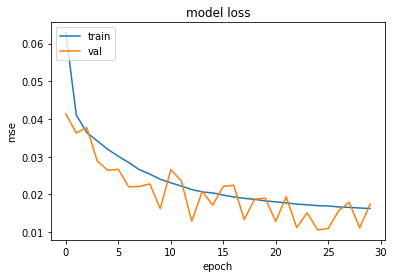

In [16]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 예측하기

In [17]:
auto_x = test_x
auto_x.shape

TensorShape([535, 1380, 4])

In [18]:
auto_x

<tf.Tensor: shape=(535, 1380, 4), dtype=float64, numpy=
array([[[0.99356031, 0.99356031, 0.99047661, 0.99102145],
        [0.99077082, 0.99304819, 0.99035674, 0.9926886 ],
        [0.99271041, 0.99356031, 0.99131566, 0.99179506],
        ...,
        [1.00163448, 1.00167799, 0.99921548, 0.99954236],
        [0.99954236, 1.00016344, 0.9989866 , 0.99976027],
        [1.        , 1.00246263, 1.        , 1.00026155]],

       [[0.89638358, 0.89899963, 0.8963626 , 0.89881128],
        [0.89856011, 0.89856011, 0.89429069, 0.89571381],
        [0.89571381, 0.89638358, 0.89460468, 0.8963626 ],
        ...,
        [0.99947679, 1.00142312, 0.99857688, 1.00008368],
        [1.0000627 , 1.00054407, 0.99889076, 0.99981165],
        [1.        , 1.00025105, 0.99679792, 0.99838853]],

       [[0.95153993, 0.95309114, 0.95149213, 0.95282489],
        [0.95282507, 0.95292419, 0.95209217, 0.95233381],
        [0.95249373, 0.95266843, 0.95241386, 0.95262241],
        ...,
        [0.99944448, 1.00000811

In [19]:
submission = np.zeros((535, 120, 4))

In [20]:
submission

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [21]:
trained_model = load_model('./save_models/Attention_based_LSTM_v7_25_0.01058.h5')

In [22]:
end_ = 120
output_window = 60

for i in range(end_//output_window):
    start_ = i*output_window
    next_ = trained_model.predict(auto_x[:, -170:, :], batch_size=128)    
    auto_x = tf.concat([auto_x, next_], axis=1)
    print(auto_x.shape)
    submission[:, start_ : start_ + output_window, :] = next_

(535, 1440, 4)
(535, 1500, 4)


In [23]:
submission

array([[[1.00143921, 1.00779951, 1.00133181, 0.99634945],
        [1.00406849, 1.00207031, 1.00422859, 1.00414884],
        [1.00475359, 0.9988445 , 0.99620813, 0.99575216],
        ...,
        [1.00307858, 0.99821359, 0.99954838, 1.00161445],
        [0.99812305, 1.00852227, 0.99890041, 1.00103855],
        [1.00661099, 1.00223029, 0.99890375, 1.00745738]],

       [[1.00053859, 1.00635254, 0.99907041, 0.99499631],
        [1.00227928, 1.0018115 , 1.00185168, 1.00382566],
        [1.00345516, 0.99745357, 0.99337208, 0.99532348],
        ...,
        [0.99971962, 0.99769574, 0.99727505, 0.99867427],
        [0.99733508, 1.00586617, 0.99744624, 0.99920905],
        [1.00390828, 1.00025105, 0.99660063, 1.00642991]],

       [[1.00049007, 1.00645018, 1.00033498, 0.99522889],
        [1.00257134, 1.00109756, 1.00297916, 1.00312042],
        [1.0038017 , 0.99770212, 0.9946481 , 0.99514157],
        ...,
        [1.00082767, 0.99850351, 0.99907309, 1.00067258],
        [0.99774587, 1.007409

In [24]:
submission.shape

(535, 120, 4)

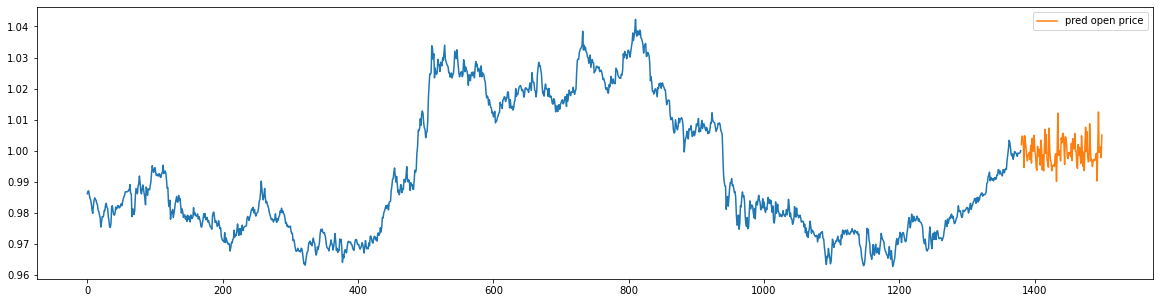

In [25]:
plt.figure(figsize=(20,5))

plt.plot(test_x[row,:,0])
plt.plot(np.arange(test_x.shape[1], test_x.shape[1]+submission.shape[1]), submission[row, :, 0], label='pred open price')
plt.legend()
plt.show()

In [26]:
sample_submission = pd.read_csv('./submission/sample_submission.csv')

In [27]:
sample_submission['buy_quantity']=1

for i in range(submission.shape[0]):
    a = submission[i,:,0].argmax()
    b = submission[i,a,0]
    c = np.array(auto_x[i,1380,0])
    
    if b > c:
        sample_submission['sell_time'][i] = a
    else:
        sample_submission['sell_time'][i] = 0

In [28]:
sample_submission['sell_time'].value_counts()

114    353
54     182
Name: sell_time, dtype: int64

In [ ]:
sample_submission.to_csv("./submission/Attention_based_LSTM_{}.csv".format(version), index = False)